In [18]:
import os
import pandas as pd

datasets = {
    'c-binding': 'Protein-peptide binding affinity',
    'binding': 'Protein-peptide binding affinity',
    'c-cpp': 'Cell penetration',
    'cpp': 'Cell penetration',
    'nc-binding': 'Protein-peptide binding affinity',
    'nc-cpp': 'Cell penetration',
    'nc-antibacterial': "Antibacterial",
    'antibacterial': "Antibacterial",
    'c-antibacterial': "Antibacterial",
    'nc-antiviral': "Antiviral",
    'antiviral': "Antiviral",
    'c-antiviral': "Antiviral"
}
datasets_sim = [
    'c-binding', 'nc-binding', 'c-cpp',
    'nc-cpp', 'c-antibacterial', 'nc-antibacterial',
    'c-antiviral', 'nc-antiviral'
]
metrics_class = {
    'acc': 'Accuracy', 'f1_weighted': 'Weighted F1',
    'mcc': 'Matthew\'s correlation coefficient',
    'auroc': "Area under the ROC curve"
}
metrics_reg = {
    'pcc': 'Pearson\'s R', 'spcc': 'Spearman\'s R',
    'rmse': 'RMSE'
}
fancy_rep = {
    'esm2-8m': 'ESM2 8M',
    'esm2-150m': "ESM2 150M",
    'prot-t5-xl': "Prot-T5-XL",
    'molformer': 'Molformer-XL',
    'chemberta': 'ChemBERTa-2',
    'pepfunn': 'PepFuNN',
    'ecfp': "ECFP-16",
    'pepclm': "PeptideCLM",
    'pepland': "Pepland",
    'avalonfp': "Avalon FP",
    'esm2-650m': "ESM2 650M",
    'protbert': "ProtBERT",
    'ecfp-count': "ECFP-16 counts",

    ## Add new representations
    # 'gram-chemberta': "Gram ChemBERTa-2",
    'chiral-ecfp': 'Chiral ECFP16',
    'esmc-300m': "ESMC 300M",
    'esmc-600m': "ESMC 600M",
    # 'fragfp-1': "Fragment FP-1",
    # 'fragfp-2': "Fragment FP-2",
    # 'new-esm2-8m': 'ESM2-8M*',
    # 'new-prot-t5-xl': 'Prot-T5-XL*',

}
hue_order = ['PLM', 'CLM', 'Chemical FP','Peptide FP', "Peptide LM/GNN"]
metrics_fancy = metrics_class 
metrics_fancy.update(metrics_reg)
REGRESSION = ['c-binding', 'nc-binding']
DPI = 512
sorted(datasets_sim)

['c-antibacterial',
 'c-antiviral',
 'c-binding',
 'c-cpp',
 'nc-antibacterial',
 'nc-antiviral',
 'nc-binding',
 'nc-cpp']

In [19]:
from compbc_utils.stats.rank_table import kruskal_wilcoxon_rank, tukey_rank


pd.options.display.float_format = '{:,.2f}'.format


def define_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['threshold'] != 'random') & (df['rep'].isin(fancy_rep))].copy()
    df['rep'] = df.rep.map(fancy_rep)
    results = {r: {} for r in df.rep.unique()}

    for dataset, t_df in df.groupby('dataset'):
        print(dataset)
        d_result = kruskal_wilcoxon_rank(t_df['GOOD'].to_numpy(), t_df['rep'].to_numpy())
        for _, row in d_result.iterrows():
            results[row['Category']][datasets[dataset]] = f'{row['Mean']:.2f}±{row['Standard error']:.2f}'

    global_df = kruskal_wilcoxon_rank(df['GOOD'].to_numpy(), df['rep'].to_numpy())
    for _, row in global_df.iterrows():
        results[row['Category']]['Average'] = f'{row['Mean']:.2f}±{row['Standard error']:.2f}'
        results[row['Category']]['Significant rank'] = row['Significant rank']
    result_df = pd.DataFrame(results).transpose()
    result_df = result_df[['Antibacterial', 'Antiviral', 'Cell penetration',
                      'Protein-peptide binding affinity',
                      'Average', 'Significant rank']]
    result_df['Significant rank'] = - result_df['Significant rank']
    result_df.sort_values(by=['Significant rank', 'Average'], inplace=True, ascending=False)
    result_df['Significant rank'] = - result_df['Significant rank']
    return result_df


def define_table_2(df: pd.DataFrame) -> pd.DataFrame:
    # df = df[(df['threshold'] != 'random') & (df['rep'].isin(fancy_rep))].copy()
    # df['rep'] = df.rep.map(fancy_rep)
    if not 'GOOD' in df:
        df['GOOD'] = df.apply(lambda x: x['spcc'] if x['dataset'] in REGRESSION else x['mcc'], axis=1)

    results = {r: {} for r in df.rep.unique()}

    for dataset, t_df in df.groupby('dataset'):
        print(dataset)
        d_result = tukey_rank(t_df['GOOD'].to_numpy(), t_df['rep'].to_numpy())
        for _, row in d_result.iterrows():
            results[row['Category']][datasets[dataset]] = f'{row['Mean']:.2f}±{row['CI']:.2f}'

    global_df = tukey_rank(df['GOOD'].to_numpy(), df['rep'].to_numpy())
    for _, row in global_df.iterrows():
        results[row['Category']]['Average'] = f'{row['Mean']:.2f}±{row['CI']:.2f}'
        results[row['Category']]['Significant rank'] = row['Significant rank']
    result_df = pd.DataFrame(results).transpose()
    result_df = result_df[['Antibacterial', 'Antiviral', 'Cell penetration',
                      'Protein-peptide binding affinity',
                      'Average', 'Significant rank']]
    result_df['Significant rank'] = - result_df['Significant rank']
    result_df.sort_values(by=['Significant rank', 'Average'], inplace=True, ascending=False)
    result_df['Significant rank'] = - result_df['Significant rank']
    return result_df

def family(rep: str) -> str:
    if 'esm' in rep.lower() or 'prot' in rep.lower():
        return 'PLM'
    elif 'chem' in rep.lower() or 'mol' in rep.lower():
        return 'CLM'
    elif rep.lower() == 'pepfunn':
        return 'Peptide FP'
    elif rep.lower() == 'peptideclm' or rep.lower() == 'pepland':
        return "Peptide LM/GNN"
    elif 'fp' in rep.lower():
        return 'Chemical FP'


In [20]:
dir = '../Results/no-generalisation'
df = pd.DataFrame()

for file in os.listdir(dir):

    path = os.path.join(dir, file)
    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['pre_pca'] = float(file.split('_')[3])
    tmp_df['post_pca'] = float(file.split('_')[5])
    tmp_df['dataset'] = file.split('_')[0]
    tmp_df['rep'] = file.split('_')[6][:-4]

    if file.split('_')[6][:-4] not in fancy_rep:
        continue
    df = pd.concat([df, tmp_df])

if not 'GOOD' in df:
    df['GOOD'] = df.apply(lambda x: x['spcc'] if x['dataset'] in REGRESSION else x['mcc'], axis=1)

df = df[df.threshold != 'random'].copy()
df.rep.value_counts()

rep
esm2-150m     620
pepfunn       620
molformer     620
pepland       620
chemberta     620
avalonfp      620
prot-t5-xl    620
ecfp-count    620
protbert      620
esm2-650m     620
esm2-8m       620
pepclm        620
ecfp          620
esmc-600m     160
esmc-300m     160
Name: count, dtype: int64

In [21]:
# Standard SVM
print("Values for SVM Standard")
df_c = df[df['dataset'].map(lambda x: x.startswith('c-'))].copy()
df_c = df_c[df_c['model'] == 'svm'].copy()
df_c = df_c[df_c['rep'] != 'new-esm2-8m'].copy()
df_c = df_c[df_c['rep'] != 'new-prot-t5-xl'].copy()
tab1 = define_table(df_c)
print(tab1.to_markdown())
tab1

Values for SVM Standard
c-antibacterial
There is significant difference with p=2.9e-66
c-antiviral
There is significant difference with p=1.8e-104
c-binding
There is significant difference with p=1.1e-89
c-cpp
There is significant difference with p=3.6e-55
There is significant difference with p=2e-208
|                | Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:---------------|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| ECFP-16        | 0.69±0.02       | 0.74±0.01   | 0.92±0.01          | 0.85±0.01                          | 0.80±0.01 |                  1 |
| PepFuNN        | 0.64±0.02       | 0.73±0.01   | 0.88±0.01          | 0.84±0.01                          | 0.77±0.01 |                  1 |
| ECFP-16 counts | 0.64±0.02       | 0.71±0.01   | 0.95±0.01          | 0.80±0.01                          | 0.77±0.01 |         

,Antibacterial,Antiviral,Cell penetration,Protein-peptide binding affinity,Average,Significant rank
ECFP-16,0.69±0.02,0.74±0.01,0.92±0.01,0.85±0.01,0.80±0.01,1
PepFuNN,0.64±0.02,0.73±0.01,0.88±0.01,0.84±0.01,0.77±0.01,1
ECFP-16 counts,0.64±0.02,0.71±0.01,0.95±0.01,0.80±0.01,0.77±0.01,1
Prot-T5-XL,0.52±0.02,0.75±0.01,0.73±0.01,0.86±0.01,0.72±0.01,2
ESM2 150M,0.31±0.01,0.51±0.01,0.73±0.02,0.54±0.01,0.52±0.01,3
ESM2 650M,0.31±0.01,0.49±0.01,0.77±0.01,0.41±0.01,0.49±0.01,3
ESM2 8M,0.29±0.01,0.44±0.02,0.69±0.01,0.53±0.01,0.48±0.01,3
ProtBERT,0.24±0.01,0.29±0.02,0.68±0.02,0.63±0.01,0.45±0.02,4
Molformer-XL,0.19±0.01,0.41±0.02,0.73±0.02,0.38±0.01,0.43±0.02,4
Avalon FP,0.22±0.01,0.40±0.02,0.68±0.02,0.42±0.00,0.43±0.01,4


In [22]:
# Standard LightGBM
print("Values for LightGBM Standard")
df_c = df[df['dataset'].map(lambda x: x.startswith('c-'))].copy()
df_c = df_c[df_c['model'] == 'lightgbm'].copy()
df_c = df_c[df_c['rep'] != 'new-esm2-8m'].copy()
df_c = df_c[df_c['rep'] != 'new-prot-t5-xl'].copy()
tab1 = define_table(df_c)
print(tab1.to_markdown())
tab1

Values for LightGBM Standard
c-antibacterial
There is significant difference with p=7.1e-06
c-antiviral
There is significant difference with p=3.1e-16
c-binding
There is significant difference with p=7.6e-46
c-cpp
There is significant difference with p=0.00015
There is significant difference with p=2.5e-29
|                | Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:---------------|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| ESM2 8M        | 0.81±0.02       | 0.78±0.01   | 0.91±0.01          | 0.90±0.01                          | 0.85±0.01 |                  1 |
| ESMC 600M      | 0.80±0.02       | 0.75±0.01   | 0.93±0.01          | 0.90±0.01                          | 0.84±0.01 |                  1 |
| ESM2 650M      | 0.81±0.02       | 0.76±0.01   | 0.92±0.01          | 0.91±0.00                          | 0.84±0.01 |    

,Antibacterial,Antiviral,Cell penetration,Protein-peptide binding affinity,Average,Significant rank
ESM2 8M,0.81±0.02,0.78±0.01,0.91±0.01,0.90±0.01,0.85±0.01,1
ESMC 600M,0.80±0.02,0.75±0.01,0.93±0.01,0.90±0.01,0.84±0.01,1
ESM2 650M,0.81±0.02,0.76±0.01,0.92±0.01,0.91±0.00,0.84±0.01,1
ECFP-16 counts,0.79±0.02,0.75±0.01,0.94±0.01,0.91±0.01,0.84±0.01,1
Prot-T5-XL,0.81±0.02,0.77±0.01,0.91±0.01,0.90±0.00,0.84±0.01,1
ESMC 300M,0.81±0.02,0.75±0.01,0.93±0.01,0.88±0.01,0.83±0.01,1
ESM2 150M,0.81±0.02,0.74±0.01,0.91±0.01,0.90±0.01,0.83±0.01,1
ECFP-16,0.77±0.02,0.74±0.01,0.92±0.01,0.90±0.01,0.83±0.01,1
ChemBERTa-2,0.80±0.02,0.73±0.01,0.90±0.01,0.89±0.01,0.82±0.01,1
ProtBERT,0.79±0.02,0.71±0.01,0.91±0.01,0.92±0.01,0.82±0.01,1


There is significant difference with p=2e-208
There is significant difference with p=2.5e-29
STD SVM: 0.24
STD LightGBM: 0.12


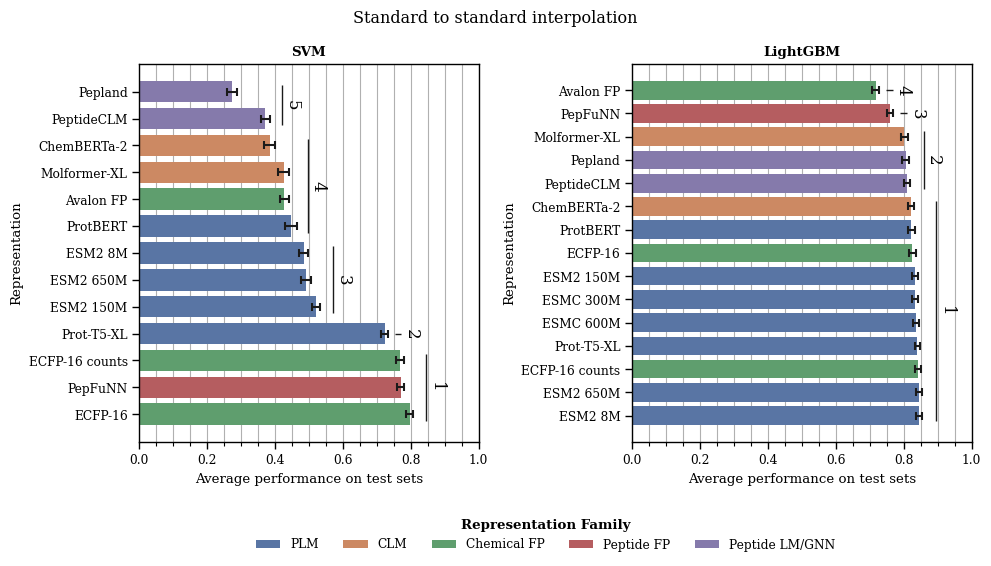

In [23]:
from compbc_utils.plots.general import start_figure, add_grid
from compbc_utils.plots.barplots import pairwise_significant_rank
import matplotlib.pyplot as plt


# Prepare data
df_c = df[df['dataset'].map(lambda x: x.startswith('c-'))].copy()
df_c = df_c[df_c['rep'] != 'new-esm2-8m'].copy()
df_c = df_c[df_c['rep'] != 'new-prot-t5-xl'].copy()
df_c.reset_index(inplace=True)
df_c['rep'] = df_c['rep'].map(fancy_rep)

# Initialize figure
fig = start_figure(10, 5, style=None, theme='paper')
axs = fig.subplots(1, 2)

# Subplot 1
axs[0] = pairwise_significant_rank(
    df_c[df_c['model'] == 'svm'].copy().reset_index(),
    metric='GOOD', groupby='rep', hue=family,
    test='non-parametric', ax=axs[0], hue_order=hue_order
)
axs[0].set_title("SVM",  fontdict={"weight": "bold"})

# Subplot 2
axs[1] = pairwise_significant_rank(
    df_c[df_c['model'] == 'lightgbm'].copy().reset_index(), metric='GOOD', groupby='rep', hue=family,
    test='non-parametric', ax=axs[1], hue_order=hue_order
)
axs[1].set_title("LightGBM", fontdict={"weight": "bold"})

# Common features
for ax in axs:
    add_grid(ax, grid_spacing=0.05)
    ax.set_ylabel("Representation")
    ax.set_xlabel("Average performance on test sets")
    ax.set_xlim(0., 1.)
    ax.legend().set_visible(False)

# Common legend
lines_labels = axs[0].get_legend_handles_labels()
lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
fig.legend(lines, labels, title='Representation Family',
          title_fontproperties={"weight": "bold"},
          loc="lower center", bbox_to_anchor=(0.55, -0.125),
          frameon=False,
          ncols=5)

plt.suptitle("Standard to standard interpolation")
fig.tight_layout()
fig.savefig('figures/interpolation_c2c.png', dpi=512, bbox_inches='tight')

print(f"STD SVM: {df_c[df_c['model'] == 'svm']['GOOD'].std():.2f}" )
print(f"STD LightGBM: {df_c[df_c['model'] == 'lightgbm']['GOOD'].std():.2f}" )

In [24]:
# Modified LightGBM
print("Values for SVM Modified")
df_nc = df[df['dataset'].map(lambda x: x.startswith('nc-'))].copy()
df_nc = df_nc[df_nc['model'] == 'svm']
tab2 = define_table(df_nc)
print(tab2.to_markdown())
tab2

Values for SVM Modified
nc-antibacterial
There is significant difference with p=2.6e-45
nc-antiviral
There is significant difference with p=1.1e-45
nc-binding
There is significant difference with p=3.8e-66
nc-cpp
There is significant difference with p=3.9e-56
There is significant difference with p=1.4e-106
|                | Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:---------------|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| Molformer-XL   | 0.88±0.01       | 0.87±0.02   | 0.85±0.01          | 0.74±0.02                          | 0.83±0.01 |                  1 |
| Prot-T5-XL     | 0.78±0.01       | 0.91±0.01   | 0.81±0.02          | 0.78±0.01                          | 0.82±0.01 |                  1 |
| ECFP-16 counts | 0.87±0.01       | 0.83±0.02   | 0.64±0.02          | 0.86±0.01                          | 0.80±0.01 |    

,Antibacterial,Antiviral,Cell penetration,Protein-peptide binding affinity,Average,Significant rank
Molformer-XL,0.88±0.01,0.87±0.02,0.85±0.01,0.74±0.02,0.83±0.01,1
Prot-T5-XL,0.78±0.01,0.91±0.01,0.81±0.02,0.78±0.01,0.82±0.01,1
ECFP-16 counts,0.87±0.01,0.83±0.02,0.64±0.02,0.86±0.01,0.80±0.01,1
Avalon FP,0.77±0.01,0.84±0.01,0.64±0.01,0.86±0.02,0.79±0.01,1
ECFP-16,0.89±0.01,0.65±0.03,0.66±0.02,0.89±0.01,0.77±0.01,1
PepFuNN,0.87±0.01,0.74±0.02,0.37±0.02,0.86±0.02,0.71±0.02,2
PeptideCLM,0.77±0.02,0.75±0.02,0.70±0.01,0.62±0.02,0.70±0.01,2
ESM2 650M,0.80±0.01,0.73±0.02,0.60±0.02,0.61±0.03,0.68±0.01,2
ChemBERTa-2,0.74±0.01,0.79±0.01,0.43±0.02,0.72±0.01,0.68±0.01,2
ESM2 150M,0.71±0.01,0.82±0.02,0.39±0.03,0.71±0.02,0.67±0.02,2


In [25]:
# Modified LightGBM
print("Values for LightGBM Modified")
df_nc = df[df['dataset'].map(lambda x: x.startswith('nc-'))].copy()
df_nc = df_nc[df_nc['model'] == 'lightgbm']
tab2 = define_table(df_nc)
print(tab2.to_markdown())
tab2

Values for LightGBM Modified
nc-antibacterial
There is significant difference with p=9.9e-15
nc-antiviral
There is significant difference with p=2.2e-18
nc-binding
There is significant difference with p=4.7e-12
nc-cpp
There is significant difference with p=5.1e-58
There is significant difference with p=1.5e-37
|                | Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:---------------|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| Molformer-XL   | 0.88±0.01       | 0.91±0.01   | 0.89±0.01          | 0.85±0.02                          | 0.88±0.01 |                  1 |
| ChemBERTa-2    | 0.87±0.00       | 0.91±0.01   | 0.84±0.02          | 0.88±0.01                          | 0.88±0.01 |                  1 |
| Prot-T5-XL     | 0.87±0.01       | 0.84±0.02   | 0.93±0.01          | 0.84±0.02                          | 0.87±0.01 |

,Antibacterial,Antiviral,Cell penetration,Protein-peptide binding affinity,Average,Significant rank
Molformer-XL,0.88±0.01,0.91±0.01,0.89±0.01,0.85±0.02,0.88±0.01,1
ChemBERTa-2,0.87±0.00,0.91±0.01,0.84±0.02,0.88±0.01,0.88±0.01,1
Prot-T5-XL,0.87±0.01,0.84±0.02,0.93±0.01,0.84±0.02,0.87±0.01,1
Avalon FP,0.83±0.01,0.90±0.01,0.72±0.01,0.90±0.01,0.85±0.01,2
ProtBERT,0.85±0.01,0.87±0.02,0.87±0.01,0.81±0.02,0.85±0.01,2
ECFP-16,0.90±0.01,0.87±0.01,0.71±0.01,0.87±0.01,0.84±0.01,2
ESM2 650M,0.89±0.00,0.91±0.01,0.72±0.01,0.80±0.02,0.83±0.01,2
PeptideCLM,0.88±0.00,0.83±0.02,0.78±0.01,0.85±0.01,0.83±0.01,2
ECFP-16 counts,0.89±0.01,0.87±0.01,0.65±0.04,0.86±0.02,0.82±0.01,2
ESM2 150M,0.86±0.01,0.91±0.01,0.60±0.02,0.82±0.02,0.80±0.01,2


There is significant difference with p=1.4e-106
There is significant difference with p=1.5e-37
STD SVM: 0.17
STD LightGBM: 0.13


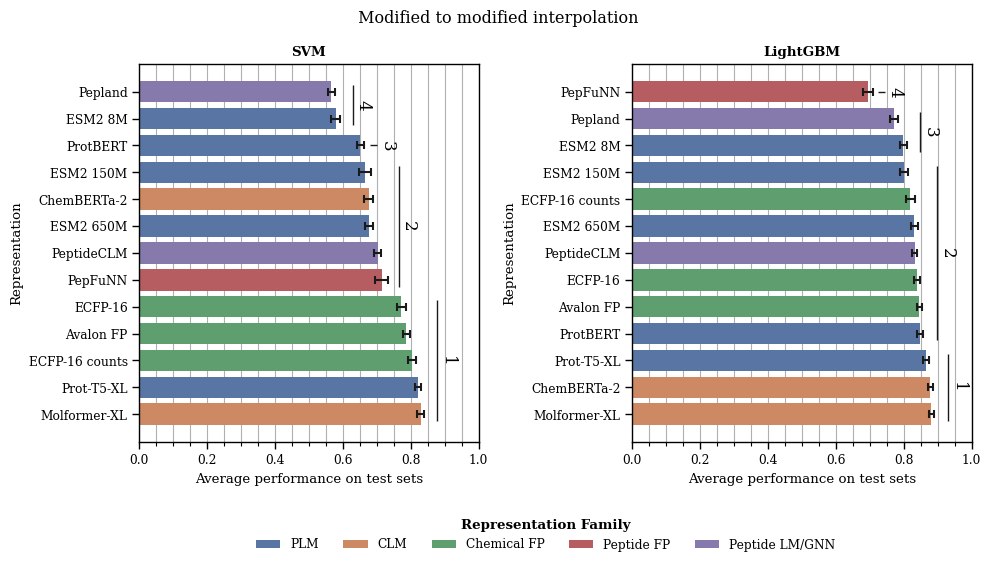

In [26]:
from compbc_utils.plots.general import start_figure, add_grid
from compbc_utils.plots.barplots import pairwise_significant_rank
import matplotlib.pyplot as plt


# Prepare data
df_c = df[df['dataset'].map(lambda x: x.startswith('nc-'))].copy()
# df_c = df_c[df_c['rep'] != 'new-esm2-8m'].copy()
df_c.reset_index(inplace=True)
df_c['rep'] = df_c['rep'].map(fancy_rep)

# Initialize figure
fig = start_figure(10, 5, style=None, theme='paper')
axs = fig.subplots(1, 2)

# Subplot 1
axs[0] = pairwise_significant_rank(
    df_c[df_c['model'] == 'svm'].copy().reset_index(), metric='GOOD', groupby='rep', hue=family,
    test='non-parametric', ax=axs[0], hue_order=hue_order
)
axs[0].set_title("SVM",  fontdict={"weight": "bold"})

# Subplot 2
axs[1] = pairwise_significant_rank(
    df_c[df_c['model'] == 'lightgbm'].copy().reset_index(), metric='GOOD', groupby='rep', hue=family,
    test='non-parametric', ax=axs[1], hue_order=hue_order
)
axs[1].set_title("LightGBM", fontdict={"weight": "bold"})

# Common features
for ax in axs:
    add_grid(ax, grid_spacing=0.05)
    ax.set_ylabel("Representation")
    ax.set_xlabel("Average performance on test sets")
    ax.set_xlim(0., 1.)
    ax.legend().set_visible(False)

# Common legend
lines_labels = axs[0].get_legend_handles_labels()
lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
fig.legend(lines, labels, title='Representation Family',
          title_fontproperties={"weight": "bold"},
          loc="lower center", bbox_to_anchor=(0.55, -0.125),
          frameon=False,
          ncols=5)

plt.suptitle(" Modified to modified interpolation")
fig.tight_layout()
fig.savefig('figures/interpolation_nc2nc.png', dpi=512, bbox_inches='tight')
print(f"STD SVM: {df_c[df_c['model'] == 'svm']['GOOD'].std():.2f}" )
print(f"STD LightGBM: {df_c[df_c['model'] == 'lightgbm']['GOOD'].std():.2f}" )

In [27]:
# Standard to modified
dir = '../Results/standard'

data = []

for file in os.listdir(dir):
    dataset = file.split('_')[0]
    rep = file.split('_')[2][:-4]
    path = os.path.join(dir, file)
    experiment = dir.split("/")[-1][0].upper() + dir.split("/")[-1][1:]
    model = file.split('_')[1]

    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['dataset'] = dataset
    tmp_df['rep'] = rep
    tmp_df['experiment'] = experiment

    if 'binding' in dataset:
        metric = 'spcc'
    else:
        metric = 'mcc'
    
    for _, m in tmp_df.iterrows():
        if m.rep not in fancy_rep:
            continue
        data.append({
            'dataset': m.dataset,
            "GOOD": m[metric],
            "Test set": " Modified",
            "model": model,
            "rep": fancy_rep[m.rep],
        })
df = pd.DataFrame(data)
print(df.model.value_counts())

model
lightgbm    1400
svm         1200
Name: count, dtype: int64


In [28]:
print("Standard to modified svm")
tab3 = define_table_2(df[(df['Test set'] == ' Modified') & (df['model'] == 'svm')])
print(tab3.to_markdown())

tab3

Standard to modified svm
antibacterial
There is significant difference with p=8.7e-31
antiviral
There is significant difference with p=9e-139
binding
There is significant difference with p=1.8e-81
cpp
There is significant difference with p=1.3e-28
There is significant difference with p=6.2e-26
|                | Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:---------------|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| PepFuNN        | 0.32±0.06       | 0.49±0.03   | -0.04±0.04         | 0.23±0.03                          | 0.25±0.04 |                  1 |
| ECFP-16        | 0.25±0.06       | 0.54±0.03   | -0.08±0.04         | 0.08±0.03                          | 0.19±0.04 |                  1 |
| ECFP-16 counts | 0.27±0.06       | 0.51±0.03   | -0.09±0.04         | 0.03±0.03                          | 0.18±0.04 |                 

,Antibacterial,Antiviral,Cell penetration,Protein-peptide binding affinity,Average,Significant rank
PepFuNN,0.32±0.06,0.49±0.03,-0.04±0.04,0.23±0.03,0.25±0.04,1
ECFP-16,0.25±0.06,0.54±0.03,-0.08±0.04,0.08±0.03,0.19±0.04,1
ECFP-16 counts,0.27±0.06,0.51±0.03,-0.09±0.04,0.03±0.03,0.18±0.04,1
ChemBERTa-2,0.02±0.06,0.14±0.03,0.03±0.04,0.37±0.03,0.14±0.04,1
Prot-T5-XL,0.08±0.06,0.01±0.03,0.01±0.04,0.34±0.03,0.11±0.04,2
ESM2 150M,0.08±0.06,-0.00±0.03,0.02±0.04,0.31±0.03,0.10±0.04,2
ESM2 650M,-0.01±0.06,0.09±0.03,0.11±0.04,0.14±0.03,0.08±0.04,2
ProtBERT,0.02±0.06,0.02±0.03,0.05±0.04,0.24±0.03,0.08±0.04,2
Pepland,0.20±0.06,-0.06±0.03,0.07±0.04,0.12±0.03,0.08±0.04,2
ESM2 8M,0.08±0.06,0.01±0.03,-0.03±0.04,0.21±0.03,0.07±0.04,2


In [29]:
print("Standard to modified lightgbm")
tab3 = define_table_2(df[(df['Test set'] == ' Modified') & (df['model'] == 'lightgbm')])
print(tab3.to_markdown())

tab3

Standard to modified lightgbm
antibacterial
There is significant difference with p=2.4e-159
antiviral
There is significant difference with p=1.2e-187
binding
There is significant difference with p=2.1e-42
cpp
There is significant difference with p=1.9e-50
There is significant difference with p=2.2e-44
|                | Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:---------------|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| PepFuNN        | 0.40±0.02       | 0.47±0.03   | -0.03±0.05         | 0.36±0.02                          | 0.30±0.04 |                  1 |
| Avalon FP      | 0.33±0.02       | 0.40±0.03   | 0.04±0.05          | 0.41±0.02                          | 0.30±0.04 |                  1 |
| ECFP-16 counts | 0.30±0.02       | 0.54±0.03   | -0.02±0.05         | 0.36±0.02                          | 0.30±0.04 |         

,Antibacterial,Antiviral,Cell penetration,Protein-peptide binding affinity,Average,Significant rank
PepFuNN,0.40±0.02,0.47±0.03,-0.03±0.05,0.36±0.02,0.30±0.04,1
Avalon FP,0.33±0.02,0.40±0.03,0.04±0.05,0.41±0.02,0.30±0.04,1
ECFP-16 counts,0.30±0.02,0.54±0.03,-0.02±0.05,0.36±0.02,0.30±0.04,1
ECFP-16,0.32±0.02,0.47±0.03,-0.12±0.05,0.36±0.02,0.26±0.04,1
ChemBERTa-2,0.31±0.02,0.39±0.03,0.02±0.05,0.26±0.02,0.25±0.04,1
Pepland,0.19±0.02,0.31±0.03,0.12±0.05,0.34±0.02,0.24±0.04,1
Chiral ECFP16,0.29±0.02,0.09±0.03,-0.07±0.05,0.36±0.02,0.17±0.04,2
Molformer-XL,0.32±0.02,0.06±0.03,-0.14±0.05,0.36±0.02,0.15±0.04,2
ESM2 150M,0.04±0.02,-0.04±0.03,0.17±0.05,0.36±0.02,0.14±0.04,2
ProtBERT,0.01±0.02,0.14±0.03,0.13±0.05,0.27±0.02,0.14±0.04,2


There is significant difference with p=6.2e-26
There is significant difference with p=2.2e-44
STD SVM: 0.18
STD LightGBM: 0.19


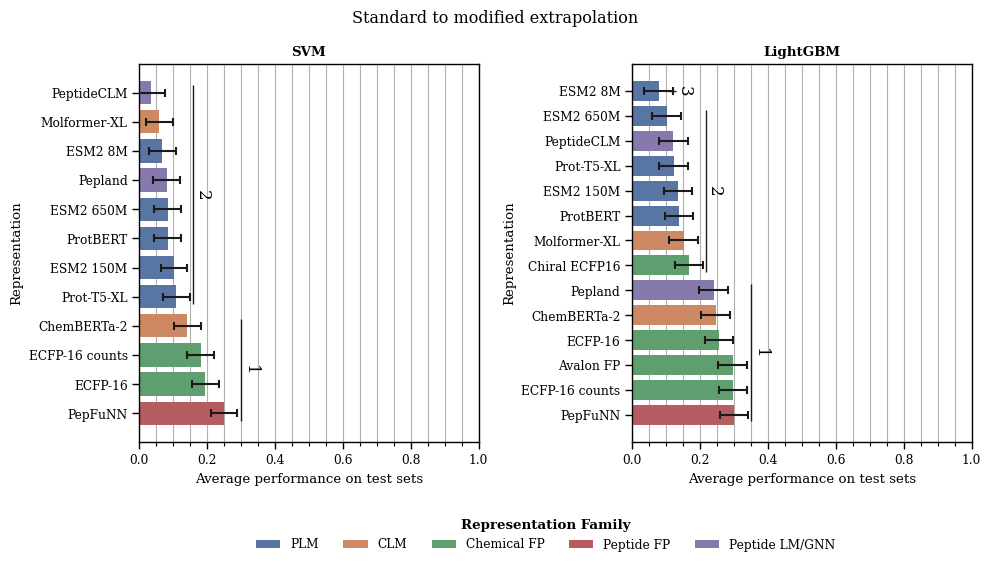

In [30]:
from compbc_utils.plots.general import start_figure, add_grid
from compbc_utils.plots.barplots import pairwise_significant_rank
import matplotlib.pyplot as plt

# Prepare data
df = df[(df['Test set'] == ' Modified')].copy().reset_index()

# Initialize figure
fig = start_figure(10, 5, style=None, theme='paper')
axs = fig.subplots(1, 2)

# Subplot 1
axs[0] = pairwise_significant_rank(
    df[df['model'] == 'svm'].copy().reset_index(),
    metric='GOOD', groupby='rep', hue=family,
    test='parametric', ax=axs[0], hue_order=hue_order
)
axs[0].set_title("SVM",  fontdict={"weight": "bold"})

# Subplot 2
axs[1] = pairwise_significant_rank(
    df[df['model'] == 'lightgbm'].copy().reset_index(),
    metric='GOOD', groupby='rep', hue=family,
    test='parametric', ax=axs[1], hue_order=hue_order
)
axs[1].set_title("LightGBM", fontdict={"weight": "bold"})

# Common features
for ax in axs:
    add_grid(ax, grid_spacing=0.05)
    ax.set_ylabel("Representation")
    ax.set_xlabel("Average performance on test sets")
    ax.set_xlim(0., 1.)
    ax.legend().set_visible(False)

# Common legend
lines_labels = axs[0].get_legend_handles_labels()
lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
fig.legend(lines, labels, title='Representation Family',
          title_fontproperties={"weight": "bold"},
          loc="lower center", bbox_to_anchor=(0.55, -0.125),
          ncols=5, frameon=False)

plt.suptitle("Standard to modified extrapolation")
fig.tight_layout()
fig.savefig('figures/extrapolation_c2nc.png', dpi=512, bbox_inches='tight')
print(f"STD SVM: {df[df['model'] == 'svm']['GOOD'].std():.2f}" )
print(f"STD LightGBM: {df[df['model'] == 'lightgbm']['GOOD'].std():.2f}" )

There is significant difference with p=1.9e-34


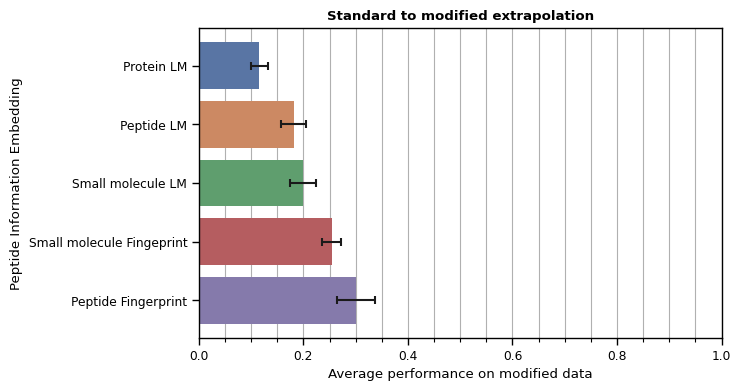

In [31]:
from compbc_utils.plots.general import start_figure, add_grid
from compbc_utils.plots.barplots import pairwise_significant_rank
import matplotlib.pyplot as plt


def family2(rep: str):
    if 'esm' in rep.lower() or 'prot' in rep.lower():
        return 'Protein LM'
    elif 'chem' in rep.lower() or 'mol' in rep.lower():
        return 'Small molecule LM'
    elif rep.lower() == 'pepfunn':
        return 'Peptide Fingerprint'
    elif rep.lower() == 'peptideclm' or rep.lower() == 'pepland':
        return "Peptide LM"
    elif 'fp' in rep.lower():
        return 'Small molecule Fingeprint'

hue_order2 = ['Protein LM', 'Small molecule LM',
              'Peptide Fingeprint', 'Peptide LM',
              'Small molecule Fingerprint']

# Prepare figure
fig = start_figure(7.5, 4, style=None, theme='paper',
                   font='sans')
df['family'] = df['rep'].map(family2)
fig = pairwise_significant_rank(
    df[(df['Test set'] == ' Modified') & (df['model'] == 'lightgbm')].copy(),
    metric='GOOD', groupby='family', hue='family',
    test='parametric', fig=fig, hue_order=df.family.unique(), no_rank=True
)
ax = fig.axes[0]
add_grid(ax, grid_spacing=0.05)
ax.legend().set_visible(False)
plt.title("Standard to modified extrapolation",
          fontdict={"weight": "bold"})
plt.ylabel("Peptide Information Embedding")
plt.xlabel("Average performance on modified data")
plt.xlim(0, 1)
fig.tight_layout()
fig.savefig('figures/talk_extrapolation_c2nc.png', dpi=512)

In [32]:
print(tab1.to_markdown(index=False))

| Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| 0.81±0.02       | 0.78±0.01   | 0.91±0.01          | 0.90±0.01                          | 0.85±0.01 |                  1 |
| 0.80±0.02       | 0.75±0.01   | 0.93±0.01          | 0.90±0.01                          | 0.84±0.01 |                  1 |
| 0.81±0.02       | 0.76±0.01   | 0.92±0.01          | 0.91±0.00                          | 0.84±0.01 |                  1 |
| 0.79±0.02       | 0.75±0.01   | 0.94±0.01          | 0.91±0.01                          | 0.84±0.01 |                  1 |
| 0.81±0.02       | 0.77±0.01   | 0.91±0.01          | 0.90±0.00                          | 0.84±0.01 |                  1 |
| 0.81±0.02       | 0.75±0.01   | 0.93±0.01          | 0.88±0.01                          | 0.83±0.01 |                  1 |


In [33]:
print(tab2.to_latex(index=False))

\begin{tabular}{llllll}
\toprule
Antibacterial & Antiviral & Cell penetration & Protein-peptide binding affinity & Average & Significant rank \\
\midrule
0.88±0.01 & 0.91±0.01 & 0.89±0.01 & 0.85±0.02 & 0.88±0.01 & 1 \\
0.87±0.00 & 0.91±0.01 & 0.84±0.02 & 0.88±0.01 & 0.88±0.01 & 1 \\
0.87±0.01 & 0.84±0.02 & 0.93±0.01 & 0.84±0.02 & 0.87±0.01 & 1 \\
0.83±0.01 & 0.90±0.01 & 0.72±0.01 & 0.90±0.01 & 0.85±0.01 & 2 \\
0.85±0.01 & 0.87±0.02 & 0.87±0.01 & 0.81±0.02 & 0.85±0.01 & 2 \\
0.90±0.01 & 0.87±0.01 & 0.71±0.01 & 0.87±0.01 & 0.84±0.01 & 2 \\
0.89±0.00 & 0.91±0.01 & 0.72±0.01 & 0.80±0.02 & 0.83±0.01 & 2 \\
0.88±0.00 & 0.83±0.02 & 0.78±0.01 & 0.85±0.01 & 0.83±0.01 & 2 \\
0.89±0.01 & 0.87±0.01 & 0.65±0.04 & 0.86±0.02 & 0.82±0.01 & 2 \\
0.86±0.01 & 0.91±0.01 & 0.60±0.02 & 0.82±0.02 & 0.80±0.01 & 2 \\
0.78±0.01 & 0.89±0.02 & 0.68±0.02 & 0.82±0.02 & 0.80±0.01 & 3 \\
0.85±0.01 & 0.78±0.01 & 0.62±0.02 & 0.83±0.01 & 0.77±0.01 & 3 \\
0.88±0.01 & 0.74±0.02 & 0.44±0.01 & 0.73±0.02 & 0.70±0.02 & 4 \\
\

In [34]:
print(tab3.to_markdown(index=False))

| Antibacterial   | Antiviral   | Cell penetration   | Protein-peptide binding affinity   | Average   |   Significant rank |
|:----------------|:------------|:-------------------|:-----------------------------------|:----------|-------------------:|
| 0.40±0.02       | 0.47±0.03   | -0.03±0.05         | 0.36±0.02                          | 0.30±0.04 |                  1 |
| 0.33±0.02       | 0.40±0.03   | 0.04±0.05          | 0.41±0.02                          | 0.30±0.04 |                  1 |
| 0.30±0.02       | 0.54±0.03   | -0.02±0.05         | 0.36±0.02                          | 0.30±0.04 |                  1 |
| 0.32±0.02       | 0.47±0.03   | -0.12±0.05         | 0.36±0.02                          | 0.26±0.04 |                  1 |
| 0.31±0.02       | 0.39±0.03   | 0.02±0.05          | 0.26±0.02                          | 0.25±0.04 |                  1 |
| 0.19±0.02       | 0.31±0.03   | 0.12±0.05          | 0.34±0.02                          | 0.24±0.04 |                  1 |
